In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

sns.set_style('white')
sns.set_context('talk')

%matplotlib inline

In [2]:
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']

In [3]:
store = pd.HDFStore('output.h5')

df_penetration = store['penetration']
df_stores = store['stores']
df_stores_data = store['stores_data']
df_operators = store['operators']
df_agents = store['agents']

store.close()

init_shares = yaml.load(open('config.yaml'))['model_parameters']['operators']['shares']

In [4]:
init_shares

[0.4, 0.28, 0.17, 0.1, 0.05]

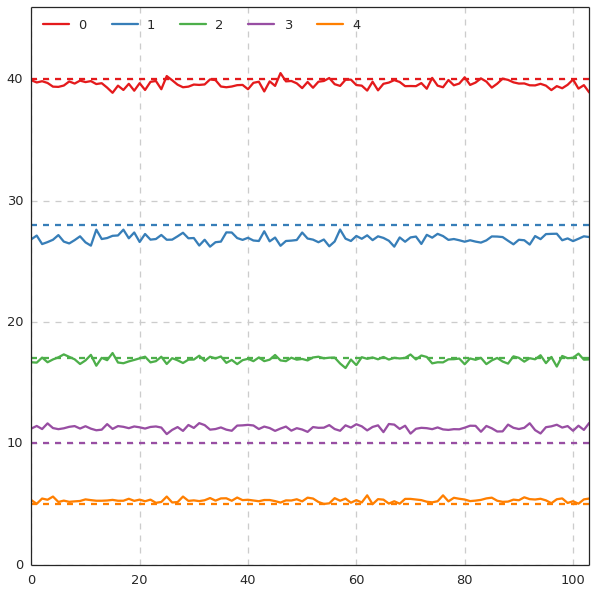

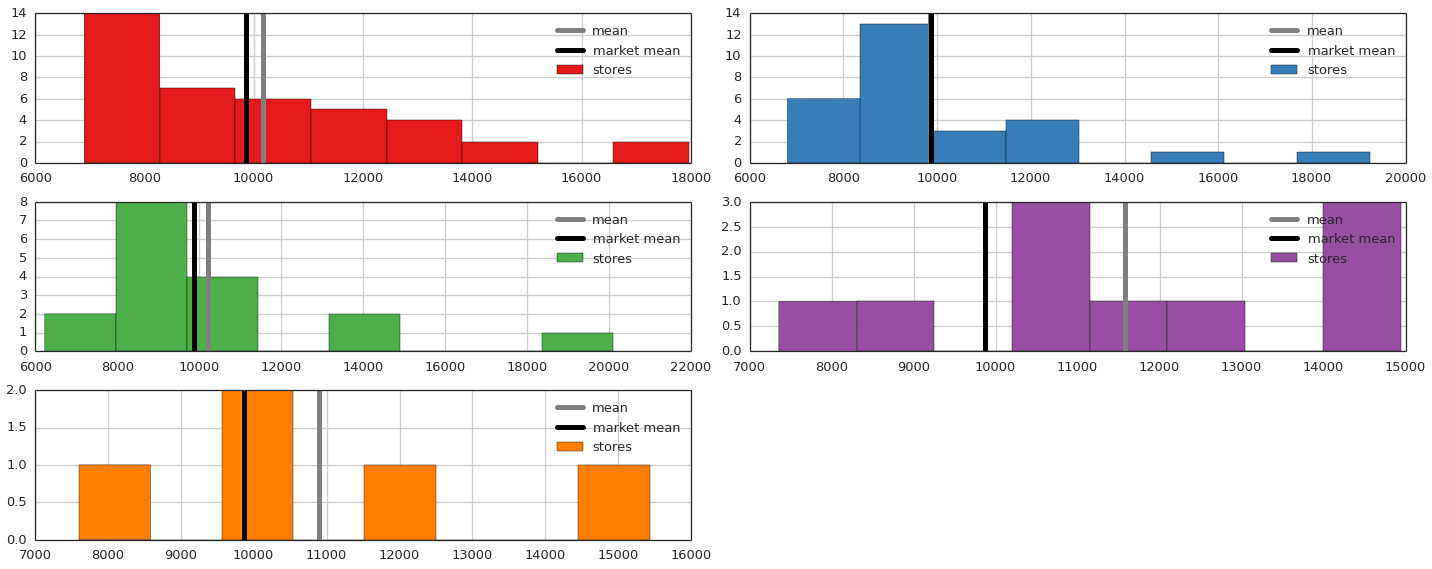

In [5]:
fig, ax = plt.subplots(figsize = (10,10))

O = len(df_operators.columns)

x = [i for i in range(len(df_operators))]
S =  1.0*sum(df_operators.values[0])
for i in range(O):
    name = 'operator_%d' % i
    ax.plot(x, df_operators[name] / S * 100.0, color = colors[i], label = '%d' % i)
    ax.plot(x,[100.0*init_shares[i] for t in range(len(x))], color = colors[i], linestyle= '--')
ax.legend(loc=2, ncol = O)
ax.grid(linestyle='--')
ax.set_xlim(min(x), max(x))
ax.set_ylim(0,100*max(init_shares) * 1.15)

cols = 2
rows = 3
fig, axs = plt.subplots(rows, cols, figsize = (20,8))
_axs = axs.reshape(-1)

gb = df_stores_data.groupby('operator_id')
ops = gb.groups.keys()
ops.sort()
stores = {}
total_visits = 0
for op in ops:
    df = gb.get_group(op)
    gsids = df.gsid.values.tolist()
    stores[op] = []
    for s in gsids:
        visits = df_stores['S%d' %s].sum()
        stores[op].append(visits)
        total_visits += visits
    
av_market_visits = total_visits / (1.0*len(df_stores))

for op in ops:
    df = pd.DataFrame({'store_visits' : stores[op]} ) #, 'stores' : op_stores[op]})
    ax = _axs[op]
    df.store_visits.hist(bins = 8, ax=ax, color = colors[op], label = 'stores')
    av = df.store_visits.mean()
    ax.axvline(av, color = 'gray', label = 'mean', linewidth = 5)
    ax.axvline(av_market_visits, color = 'k', linestyle = '-', label = 'market mean', linewidth = 5)
    ax.legend()
fig.tight_layout()
_axs[5].set_visible(False)

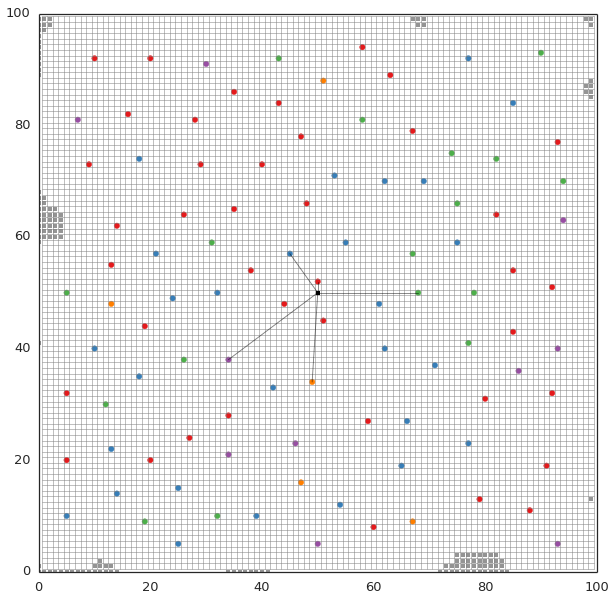

In [6]:

def plot_market(df_agents, df_stores_data, ax, example = None):
    palette = sns.color_palette()
    n = 0
    N = int(np.sqrt(len(df_agents)))
    for i in range(N):
        x = []
        y = []
        for j in range(N):
            x.append(i+0.5)
            y.append(j+0.5)
        ax.plot(x,y, color = 'gray', linestyle = '-', linewidth = 0.5)
        ax.plot(y,x, color = 'gray', linestyle = '-', linewidth = 0.5)
        
    for i, row in df_agents.iterrows():
        i = row['x']
        j = row['y']
        sprob = row['total_prob']
        
        
        if sprob == 0.0: #No available operator to shop
            n += 1
            ax.plot([i,i],[j,j], marker = 's', color = 'gray', markersize = 4, alpha = 0.6)
        
        if example != None:
            if example['i'] == i and example['j'] == j:
                for s in range(O):
                    name = 'gsid_%d' % s
                    gsid = row[name]
                    df = df_stores_data[df_stores_data['gsid'] == gsid]
                    posx = df['x'].values[0]
                    posy = df['y'].values[0]
                    ax.plot([i,posx], [j, posy], color = 'k', alpha = 0.5, linewidth = 0.9)
                ax.plot([i,i], [j,j], marker  = 's', markersize = 4, color = 'k')
                    
        
    for i, row in df_stores_data.iterrows():
        ax.scatter(row['x'], row['y'], color = colors[row['operator_id']], s = 30)
    ax.set_xlim(0,N)
    ax.set_ylim(0,N)
    


fig, ax = plt.subplots(figsize = (10,10))
example = {'i' : 50, 'j' : 50}
#example = None
plot_market(df_agents, df_stores_data, ax, example = example)

#df_stores_data

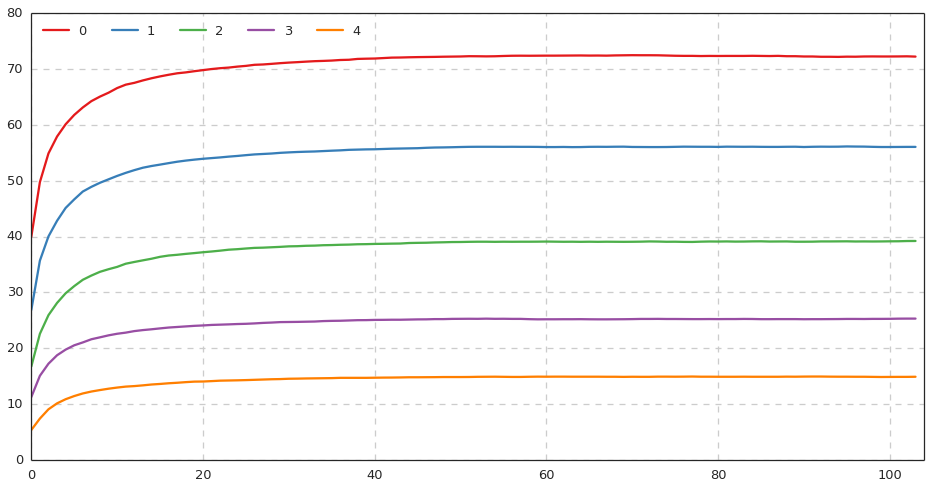

In [7]:
fig, ax = plt.subplots(figsize = (16,8))
S =  1.0*sum(df_operators.values[0])
O = 5
name = 'operator_%d' % 0
T = len(df_penetration[name])
x = [i for i in range(T)]
for i in range(O):
    name = 'operator_%d' % i
    ax.plot(x, df_penetration[name]/S * 100, color = colors[i], label = '%d' % i)
ax.grid(linestyle='--')
ax.set_xlim(0,T)
ax.legend(loc = 2, ncol = O)